In [1]:
import datetime
import os
import yaml

import numpy as np
import pandas as pd

In [3]:
ENV_FILE = '../env.yaml'
with open(ENV_FILE) as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

# Initialisation des chemins vers les fichiers
ROOT_DIR = os.path.dirname(os.path.abspath(ENV_FILE))
DATA_FILE = os.path.join(ROOT_DIR, 
                         params['directories']['processed'], 
                         params['files']['all_data'])

# Lecture du fichiers des données
epidemie_df = (pd.read_csv(DATA_FILE, parse_dates=["Last Update"])
               .assign(day=lambda _df: _df['Last Update'].dt.date)
               .drop_duplicates(subset=['Country/Region', 'Province/State', 'day'])
               [lambda df: df.day <= datetime.date(2020, 3, 27)]
              )

In [4]:
france_df = (epidemie_df[epidemie_df['Country/Region'] == 'France']
             .groupby(['Country/Region', 'day'])
             .agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})
             .reset_index()
            )

france_df.tail()

,Country/Region,day,Confirmed,Deaths,Recovered
37,France,2020-03-23,20123.0,862.0,2207.0
38,France,2020-03-24,22622.0,1102.0,3288.0
39,France,2020-03-25,25600.0,1333.0,3907.0
40,France,2020-03-26,29551.0,1698.0,4955.0
41,France,2020-03-27,33402.0,1997.0,5707.0


- S : Susceptible
- I : Infected
- R : Recovered

In [5]:
france_df = (epidemie_df[epidemie_df['Country/Region'] == 'France']
             .groupby(['Country/Region', 'day'])
             .agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})
             .reset_index()
            )

france_df.tail()

,Country/Region,day,Confirmed,Deaths,Recovered
37,France,2020-03-23,20123.0,862.0,2207.0
38,France,2020-03-24,22622.0,1102.0,3288.0
39,France,2020-03-25,25600.0,1333.0,3907.0
40,France,2020-03-26,29551.0,1698.0,4955.0
41,France,2020-03-27,33402.0,1997.0,5707.0


In [6]:
def get_country(self, country):
    return(epidemie_df[epidemie_df['Country/Region'] == country]
           .groupby(['Country/Region', 'day'])
           .agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})
           .reset_index()
          )

# Monkey patch pd.DataFrame
pd.DataFrame.get_country = get_country

In [7]:
italy_df = epidemie_df.get_country('Italy')

In [8]:
korea_df = get_country(epidemie_df, 'South Korea')
korea_df.tail()

# epidemie_df.get_country('South Korea').head()

,Country/Region,day,Confirmed,Deaths,Recovered
55,South Korea,2020-03-23,8961.0,111.0,3166.0
56,South Korea,2020-03-24,9037.0,120.0,3507.0
57,South Korea,2020-03-25,9137.0,126.0,3730.0
58,South Korea,2020-03-26,9241.0,131.0,4144.0
59,South Korea,2020-03-27,9332.0,139.0,4528.0


In [9]:
korea_df['infected'] = korea_df['Confirmed'].diff()
italy_df['infected'] = italy_df['Confirmed'].diff()

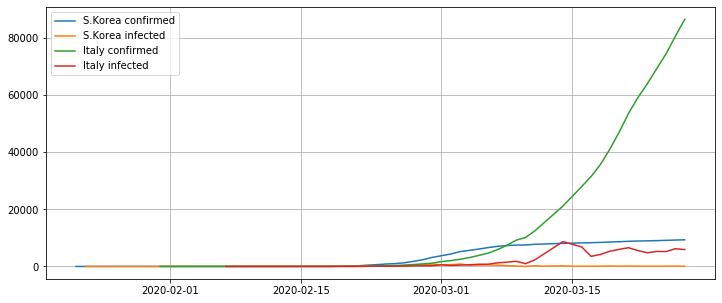

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12, 5))
plt.plot(korea_df.day, korea_df.Confirmed, label='S.Korea confirmed');
plt.plot(korea_df.day, korea_df.infected, label='S.Korea infected');
plt.plot(italy_df.day, italy_df.Confirmed, label='Italy confirmed');
plt.plot(italy_df.day, italy_df.infected, label='Italy infected');
plt.grid(True)
plt.legend()
plt.show()

In [11]:
def SIR(t, y):
    S = y[0]
    I = y[1]
    R = y[2]
    return([-beta*S*I, beta*S*I-gamma*I, gamma*I])

In [12]:
korea_df.loc[2:].head()

,Country/Region,day,Confirmed,Deaths,Recovered,infected
2,South Korea,2020-01-24,2.0,0.0,0.0,1.0
3,South Korea,2020-01-25,2.0,0.0,0.0,0.0
4,South Korea,2020-01-26,3.0,0.0,0.0,1.0
5,South Korea,2020-01-27,4.0,0.0,0.0,1.0
6,South Korea,2020-01-28,4.0,0.0,0.0,0.0


In [14]:
from scipy.integrate import solve_ivp

beta, gamma = [0.01, 0.1]
nb_steps = korea_df.shape[0]
solution_korea = solve_ivp(SIR, [0, nb_steps-1], [51_470_000, 1, 0], t_eval=np.arange(0, nb_steps, 1))

In [15]:
solution_korea

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 10786010
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])
 t_events: None
        y: array([[ 5.14700000e+07,  2.04872617e-07, -5.79192642e-07,
        -1.02864803e-07,  3.39434814e-07,  1.95092383e-07,
         1.56908982e-06, -5.54756490e-07,  8.55639764e-07,
        -3.84005541e-07,  1.14854677e-06,  1.04737837e-06,
         1.41446345e-07, -3.89979213e-08, -1.31579840e-06,
        -1.17991062e-06, -5.32379870e-07,  6.79204480e-07,
        -7.21960552e-07, -4.83684927e-07, -5.40636688e-07,
         5.00739636e-09, -2.42491836e-07, -4.15623310e-07,
         5.38168115e-07, -1.20506229e-08,  4.330

In [18]:
def plot_epidemia(solution, infected, susceptible=False):
    fig = plt.figure(figsize=(12, 5))
    if susceptible:
        plt.plot(solution.t, solution.y[0])
    plt.plot(solution.t, solution.y[1])
    plt.plot(solution.t, solution.y[2])
    plt.plot(infected.reset_index(drop=True).index, infected, "k*:")
    plt.grid("True")
    if susceptible:
        plt.legend(["Susceptible", "Infected", "Recovered", "Original Data"])
    else:
        plt.legend(["Infected", "Recovered", "Original Data"])
    plt.show()

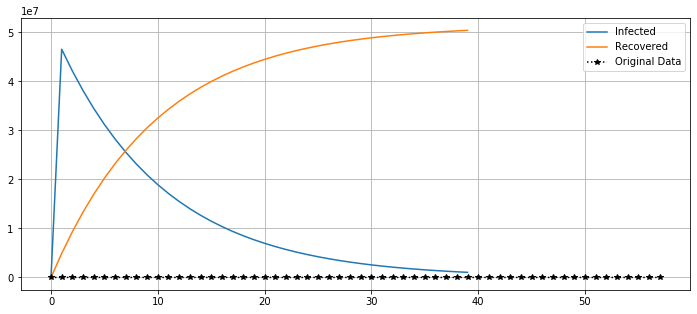

In [16]:
plot_epidemia(solution_korea, korea_df.loc[2:]['infected'])

### Approximation

In [21]:
korea_df['infected'].max()

851.0

In [22]:
# Max number of infected individuals in one day
korea_df['infected'].diff().max()

252.0

In [23]:
(korea_df['Recovered'].diff().loc[korea_df['infected'] != 0] / korea_df.loc[korea_df['infected'] != 0]['infected']).mean()

1.1026950458544795

In [24]:
beta, gamma = [0.001, 0.1]
solution_korea = solve_ivp(SIR, [0, 40], [51_470_000, 1, 0], t_eval=np.arange(0, 41, 1))

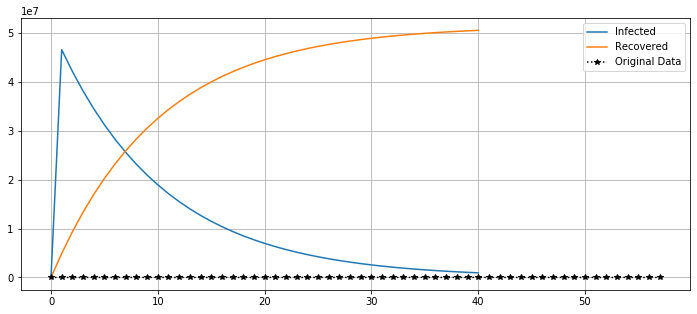

In [26]:
plot_epidemia(solution_korea, korea_df.loc[2:]['infected'])

In [13]:
def sumsq_error(parameters):
    beta, gamma = parameters
    
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return([-beta*S*I, beta*S*I-gamma*I, gamma*I])

    solution = solve_ivp(SIR, [0, nb_steps-1], [total_population, 1, 0], t_eval=np.arange(0, nb_steps, 1))
    
    return(sum((solution.y[1]-infected_population)**2))

In [14]:
total_population = 51_470_000
infected_population = korea_df.loc[2:]['infected']
nb_steps = len(infected_population)

In [29]:
%%time
from scipy.optimize import minimize

msol = minimize(sumsq_error, [0.001, 0.1], method='Nelder-Mead')
msol.x

Wall time: 23min 53s


array([ 0.05027051, 26.66732464])

In [15]:
beta_optimal = 0.05027051
gamma_optimal = 26.66732464

In [16]:
beta = beta_optimal
gamma = gamma_optimal

def SIR(t, y):
    S = y[0]
    I = y[1]
    R = y[2]
    return([-beta*S*I, beta*S*I-gamma*I, gamma*I])

solution_korea_optimal = solve_ivp(SIR, [0, 57], [51_470_000*0.1, 1, 0], t_eval=np.arange(0, 57, 1))

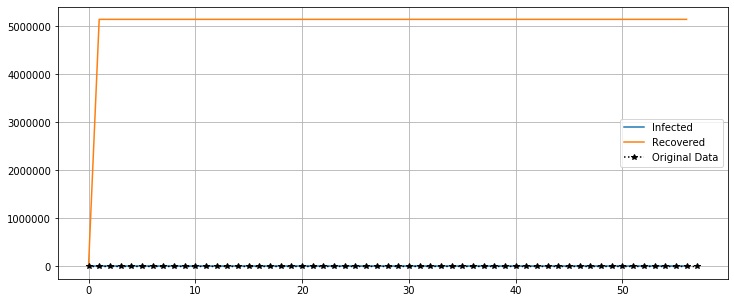

In [19]:
plot_epidemia(solution_korea_optimal, korea_df.loc[2:]['infected'])

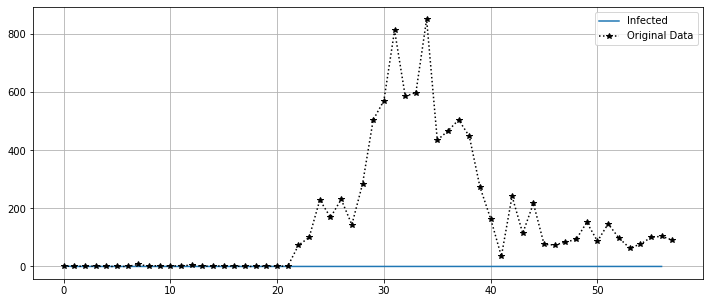

In [20]:
fig = plt.figure(figsize=(12, 5))
plt.plot(solution_korea_optimal.t, solution_korea_optimal.y[1])
plt.plot(korea_df.loc[2:]['infected'].reset_index(drop=True).index, korea_df.loc[2:]['infected'], "k*:")
plt.grid("True")
plt.legend(["Infected", "Original Data"])
plt.show()

In [21]:
china_df = epidemie_df.get_country('China')#[:49]

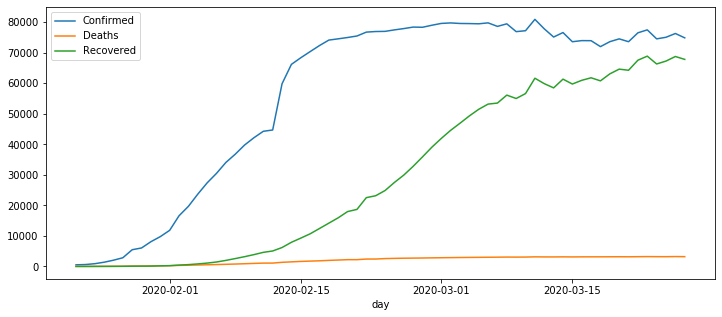

In [22]:
china_df.set_index('day').plot.line(figsize=(12,5))

In [23]:
%%time
beta, gamma = [0.001, 0.1]
china_df['infected'] = china_df['Confirmed'].diff()
nb_steps = china_df.shape[0]
solution_china = solve_ivp(SIR, [0, nb_steps-1], [1_350_470_000, 1, 0], t_eval=np.arange(0, nb_steps, 1))

Wall time: 18min 52s


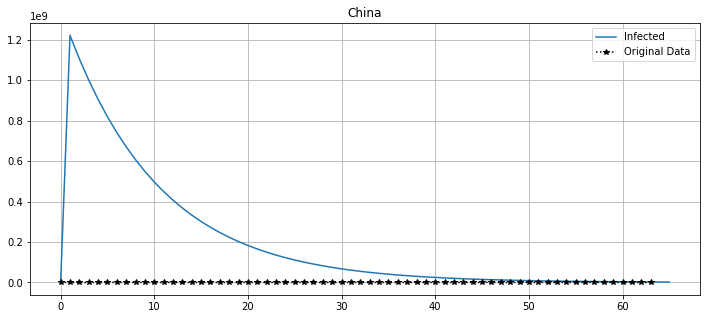

In [24]:
fig = plt.figure(figsize=(12, 5))
plt.plot(solution_china.t, solution_china.y[1])
plt.plot(china_df.loc[2:]['infected'].reset_index(drop=True).index, china_df.loc[2:]['infected'], "k*:")
plt.title('China')
plt.grid("True")
plt.legend(['Infected', "Original Data"])
plt.show()

In [20]:
korea_df['infected']

0       NaN
1       0.0
2       1.0
3       0.0
4       1.0
5       1.0
6       0.0
7       0.0
8       0.0
9       7.0
10      1.0
11      3.0
12      1.0
13      3.0
14      4.0
15      1.0
16      1.0
17      2.0
18      1.0
19      0.0
20      0.0
21      1.0
22      1.0
23      1.0
24     73.0
25    100.0
26    229.0
27    169.0
28    231.0
29    144.0
30    284.0
31    505.0
32    571.0
33    813.0
34    586.0
35    599.0
36    851.0
37    435.0
38    467.0
39    505.0
40    448.0
41    273.0
42    164.0
43     35.0
44    242.0
45    114.0
46    217.0
47     76.0
48     74.0
49     84.0
50     93.0
51    152.0
52     87.0
53    147.0
54     98.0
55     64.0
56     76.0
57    100.0
58    104.0
59     91.0
Name: infected, dtype: float64

In [89]:
# Limite modèle SIR: pas exacte d'esposer toute la population du pays au virus.
# Prendre 10% de la population